# To summarise: 
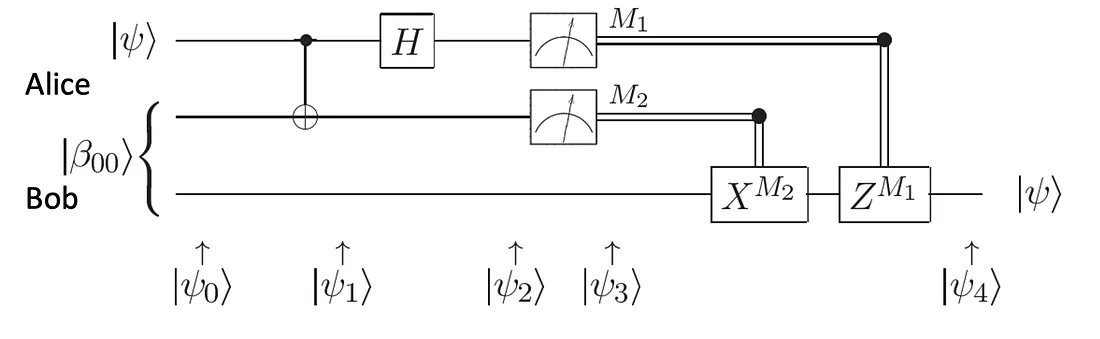
- Alice and Bob share a Bell pair, β₀₀.
- Alice wants to send an arbitrary qubit, ψ, to Bob.
- Alice has the top two qubits in the diagram, Bob has the bottom one.
- Alice applies two gates to her qubits.
- Alice measures her qubits and sends the results (classically) to Bob.
- Bob applies the appropriate corrections and recovers ψ!
---
## Preparing  ψ

The second step in our protocol is for Alice to have the qubit ψ. We’ll make it applying a quarter of an X gate. An X gate is implemented as a rotation on the x-axis, known as rx, by angle π and so to do a quarter of that we can just do and rx rotation by π/4. We will apply it on Alice’s first qubit. We’ll also add a classical register to measure it into later

/home/pwnet/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


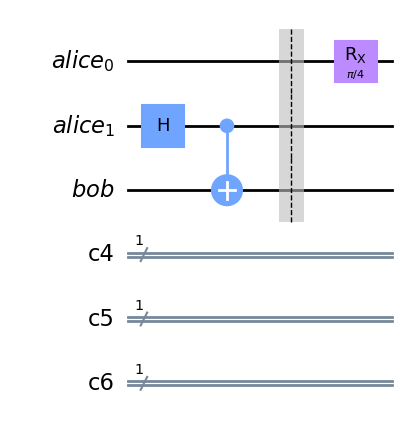

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from math import pi


# create quantum registers for alice and bob
alice_reg = QuantumRegister(2, 'alice')
bob_reg = QuantumRegister(1, 'bob')
qc = QuantumCircuit(alice_reg, bob_reg)

# apply h gate to alice's second qubit
qc.h(alice_reg[1])
# apply cx gate with alice's second qubit as control and bob's qubit as target
qc.cx(alice_reg[1], bob_reg[0])
alice_bell_class_reg = ClassicalRegister(1) # create classical register for alice bell pair 
bob_class_reg = ClassicalRegister(1) # create classical register for bob

# add classical registers to the circuit
qc.add_register(alice_bell_class_reg) 
qc.add_register(bob_class_reg) 

qc.barrier() # draw barrier to separate gates
# apply rx gate to alice's first qubit with 
qc.rx(pi/4, alice_reg[0]) 
alice_psi_class_reg = ClassicalRegister(1) # create classical register for alice psi
# add classical register to the circuit
qc.add_register(alice_psi_class_reg)
qc.draw(output='mpl')


# The Actual Circuit
In terms of our circuit diagram, we are now at ψ₀. So all we need to do is apply our two gates:

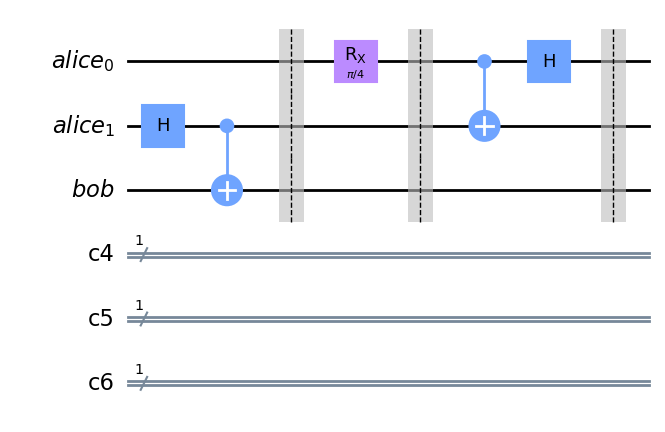

In [9]:
qc.barrier() # draw barrier to separate gates
qc.cx(alice_reg[0], alice_reg[1]) # apply cx gate with alice's first qubit as control and alice's second qubit as target
qc.h(alice_reg[0])  # apply h gate to alice's first qubit
qc.barrier() # draw barrier to separate gates
qc.draw(output='mpl')

Next, we’ll measure Alice’s qubits and then to send the information, you can use <spin style="background-color: #4c00b0">qiskit.c_if</spin> as follows:

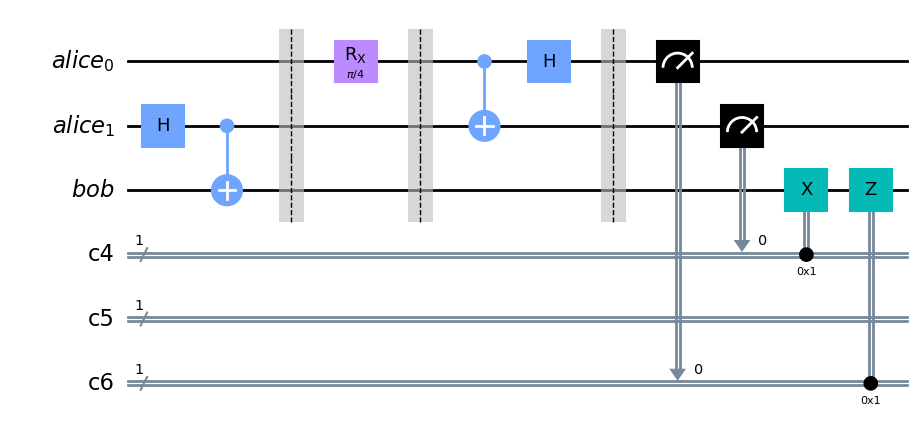

In [10]:
qc.measure(alice_reg[0], alice_psi_class_reg) # measure alice's first qubit
qc.measure(alice_reg[1], alice_bell_class_reg) # measure alice's second qubit
qc.x(bob_reg[0]).c_if(alice_bell_class_reg, 1) # Apply X to Bob if 2nd qubit measured to 1
qc.z(bob_reg[0]).c_if(alice_psi_class_reg, 1) # Apply Z if 1st qubit measured to 1
qc.draw(output='mpl')

The qubit has now been teleported and recovered! Finally, we’ll apply that -π/4 gate to ensure we measure zeros and then measure Bob’s qubit:


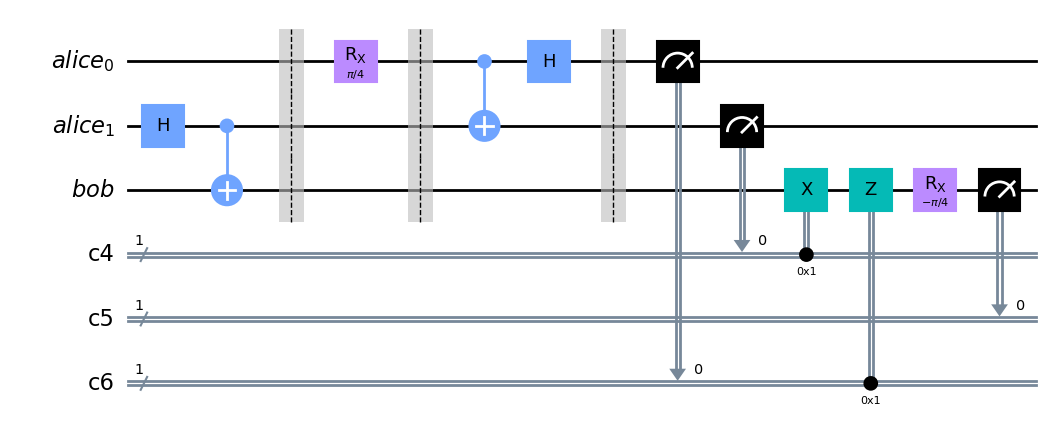

In [11]:
qc.rx(-pi/4, bob_reg[0]) # apply rx gate to bob's qubit
qc.measure(bob_reg[0], bob_class_reg) # measure bob's qubit
qc.draw(output='mpl')

Running the simulation: 

In [12]:
from qiskit import BasicAer, execute
backend = BasicAer.get_backend('qasm_simulator') # set the backend to qasm_simulator
results = execute(qc, backend=backend).result() # run the circuit on the backend and get the results
results.get_counts() # get the counts

{'0 0 1': 242, '1 0 0': 267, '1 0 1': 247, '0 0 0': 268}

The results look pretty random but when comparing to the final circuit diagram,  We see that the first and last qubits are the ones used for the correction. These happen randomly. More importantly, notice that the middle qubit is always 0. That is the one we teleported! So not only did we successfully teleport the qubit ψ, but we also correctly recovered it for every combination of Alice’s measurement.

# Teleporting on a real device 
So we are finally ready for the grand finale.But we can’t actually use the classical communication channels on real quantum computers yet. So to solve this problem we need to make a small adjustment to our circut. 
- We’re going to have to get rid of the c_if commands and replace them with CNOT and CZ
- And, Since we now no longer need to measure Alice’s qubits, we may as well delete those classical registers. Then, in the block which previously had the c_if operations write:

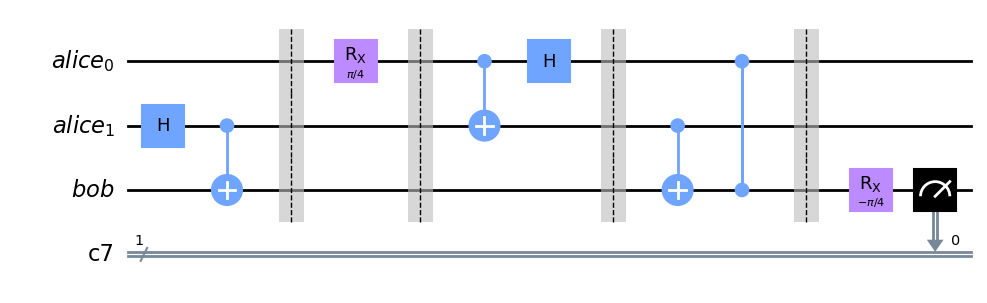

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from math import pi
# create quantum registers for alice and bob
alice_reg = QuantumRegister(2, 'alice')
bob_reg = QuantumRegister(1, 'bob')
qc = QuantumCircuit(alice_reg, bob_reg)

# apply h gate to alice's second qubit
qc.h(alice_reg[1])
# apply cx gate with alice's second qubit as control and bob's qubit as target
qc.cx(alice_reg[1], bob_reg[0])
bob_class_reg = ClassicalRegister(1) # create classical register for bob

# add classical registers to the circuit
qc.add_register(bob_class_reg) 

qc.barrier() # draw barrier to separate gates
# apply rx gate to alice's first qubit with 
qc.rx(pi/4, alice_reg[0]) 

qc.barrier() # draw barrier to separate gates
qc.cx(alice_reg[0], alice_reg[1]) # apply cx gate with alice's first qubit as control and alice's second qubit as target
qc.h(alice_reg[0])  # apply h gate to alice's first qubit
qc.barrier() # draw barrier to separate gates

qc.cx(alice_reg[1], bob_reg[0])
qc.cz(alice_reg[0], bob_reg[0])

qc.barrier() # draw barrier to separate gates
qc.rx(-pi/4, bob_reg[0]) # apply rx gate to bob's qubit
qc.measure(bob_reg, bob_class_reg) # measure bob's qubit


qc.draw(output='mpl')


This circuit we can run on an actual quantum computer. So let’s do it:

ibmqfactory.load_account:WARNING:2024-01-19 22:36:07,215: Credentials are already in use. The existing account in the session will be replaced.


ibm_kyoto
{'1': 1310, '0': 8690}


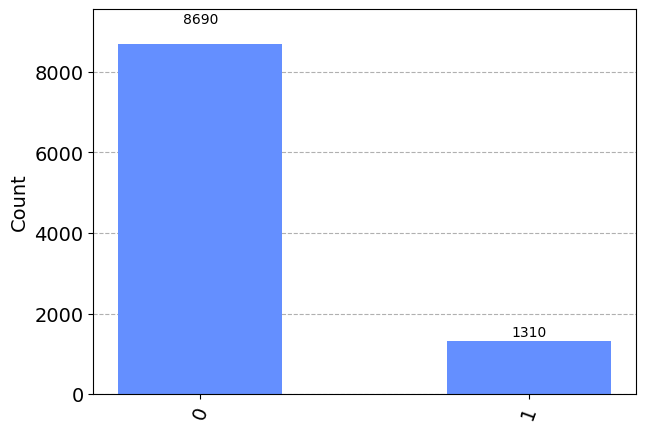

In [14]:
from qiskit import IBMQ
from qiskit import execute
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
IBMQ.save_account(open("token1.txt","r").read(), overwrite=True) 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q') # get the provider
backend = least_busy(provider.backends(simulator=False)) # get the least busy backend
print(backend)  # print the least busy backend
job_exp = execute(qc, backend=backend, shots=10000) # run the job on the least busy backend
exp_result = job_exp.result() # get the result from the job
exp_measurement_result = exp_result.get_counts(qc) # get the counts from the result
print(exp_measurement_result) # print the counts
plot_histogram(exp_measurement_result) # plot the histogram of the counts

We can see that we got 0 an overwhelming number of times, the small fraction of 1 results being due to errors.